## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

dataset, metadata = tfds.load('cifar10', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
IMG_SIZE = 32

## **Information about the Dataset**

In [15]:
class_names = metadata.features["label"].names
print(f"Class names: {class_names}")

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print(f"Number of training examples: {num_train_examples}")
print(f"Number of test examples:     {num_test_examples}")

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of training examples: 50000
Number of test examples:     10000


## **Dataset Image Visualization**

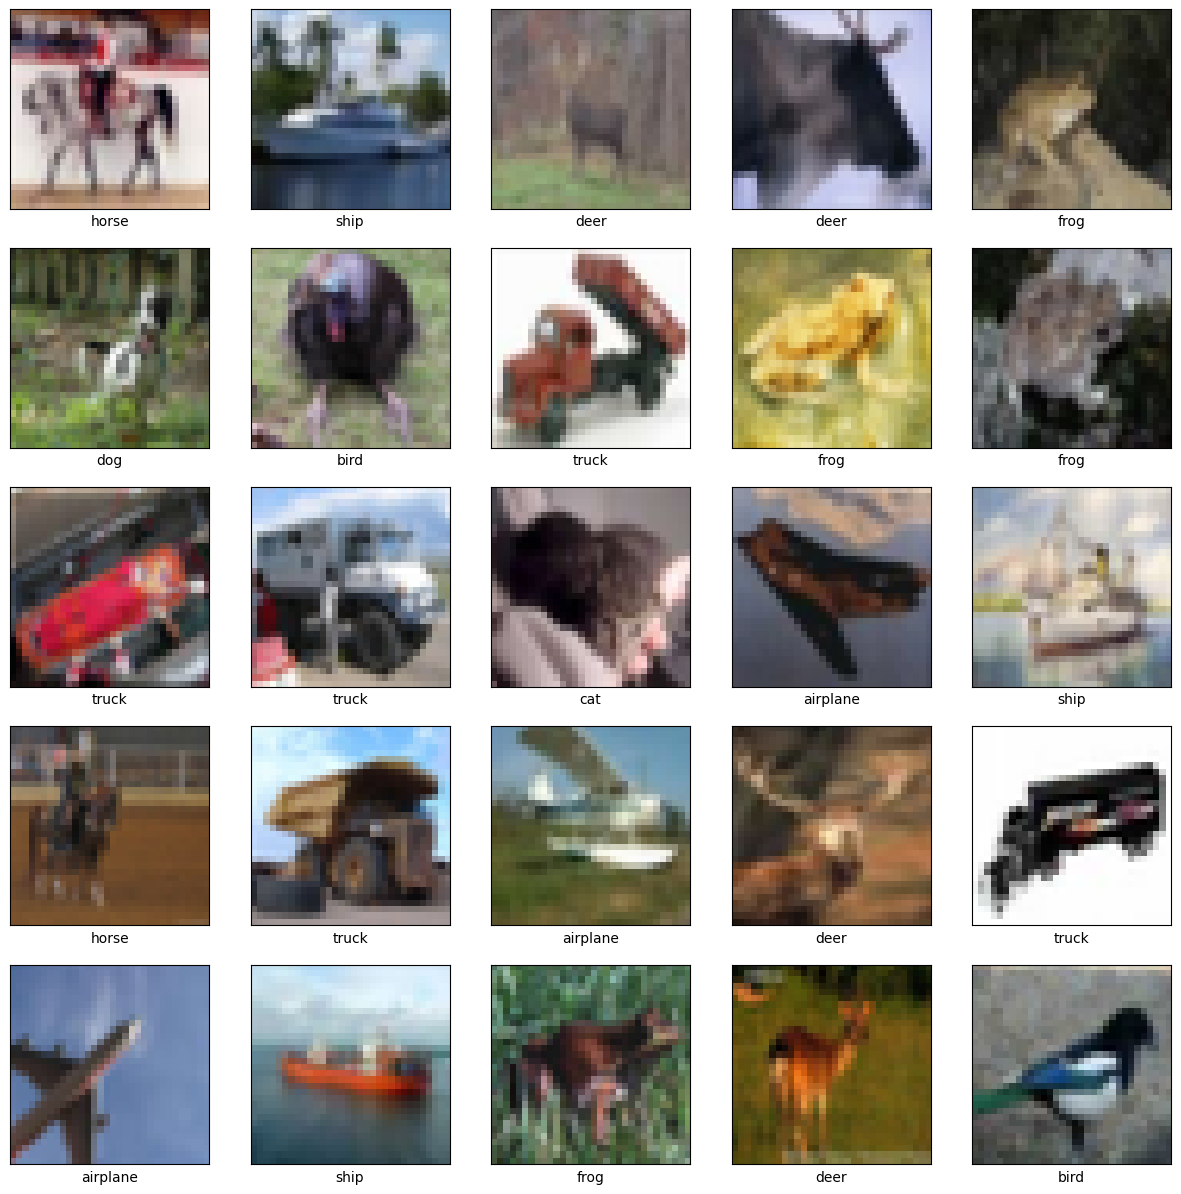

In [16]:
plt.figure(figsize=(15,15))
for i, (image, label) in enumerate(train_dataset.take(25)):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[label])
    plt.imshow(image)
plt.show()

## **Normalization**

Normalization in neural networks is a **vital preprocessing** technique that scales input data to a consistent range, such as [0, 1] or [-1, 1]. This **enhances training stability, speeds up convergence, and reduces computational complexity while minimizing sensitivity to weight initialization**. 

Common methods include Min-Max Normalization, which scales values to a specified range, and Z-Score Normalization, which standardizes values to have a mean of 0 and a standard deviation of 1. Normalizing image data typically involves adjusting pixel values from 0 to 255 to a [0, 1] range. Overall, normalization significantly boosts a neural network's performance and reliability.

In [17]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

## **Effects of Normalization on Image Pixel Values**

Values of the First Pixel in Each Color Channel:

Red:0.5607843399047852
Green: 0.3764705955982208
Blue: 0.3764705955982208


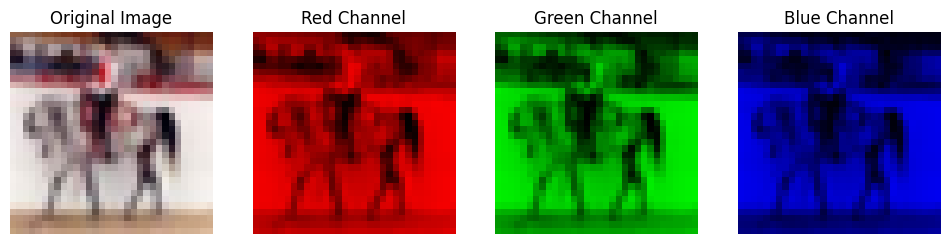

In [18]:
for image, label in train_dataset.take(1):

    red_channel = np.copy(image)
    green_channel = np.copy(image)
    blue_channel = np.copy(image)

    red_channel[:, :, 1] = 0
    red_channel[:, :, 2] = 0

    green_channel[:, :, 0] = 0
    green_channel[:, :, 2] = 0

    blue_channel[:, :, 0] = 0
    blue_channel[:, :, 1] = 0

    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(red_channel)
    axs[1].set_title("Red Channel")
    axs[1].axis('off')

    axs[2].imshow(green_channel)
    axs[2].set_title("Green Channel")
    axs[2].axis('off')

    axs[3].imshow(blue_channel)
    axs[3].set_title("Blue Channel")
    axs[3].axis('off')

    print(f"Values of the First Pixel in Each Color Channel:\n\nRed:{image[0, 0, 0]}\nGreen: {image[0, 0, 1]}\nBlue: {image[0, 0, 1]}")

plt.show()


## **Model Creation**

In [19]:
def create_model(conv_layers=3, dense_layers= 1, dropout_rate=0.1, l2_regularization=0.01):
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    for _ in range(conv_layers-1):
        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))

    dense_neurons = 512
    for _ in range(dense_layers):
        model.add(Dense(dense_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)))
        model.add(Dropout(dropout_rate))
        dense_neurons //= 2

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


In [20]:
def iterate_and_create_models(X_train, y_train, param_grid, epochs=10, batch_size=64):
    results = []
    
    for params in param_grid:

        model = create_model(**params)
        
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        accuracy = history.history["accuracy"][-1]
        
        results.append({
            'params': params,
            'history': history
        })
        
        print(f"Trained model with {params} - Accuracy: {accuracy:.4f}")
    
    return results


In [ ]:
def plot_model_performance(results):
    plt.figure(figsize=(12, 6))
    
    for result in results:
        params = result['params']
        history = result['history'].history["accuracy"]  # Lista de accuracies ao longo das épocas
        
        param_str = ", ".join([f"{k}={v}" for k, v in params.items()])
        
        plt.plot(history, linestyle='--', label=f"{param_str}")  # Plota a lista completa de accuracies
    
    plt.title('Model Performance Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


In [21]:
def get_data_from_tfds(dataset):
    images, labels = [], []
    for img, lbl in dataset:
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

X_train, y_train = get_data_from_tfds(train_dataset)
X_val, y_val = get_data_from_tfds(test_dataset)

In [20]:
param_grid = [
    {'conv_layers': 2,'dense_layers':2},
    {'conv_layers': 3,'dense_layers':1},
    {'conv_layers': 1,'dense_layers':3},
    {'conv_layers': 3,'dense_layers':3}
]

results = iterate_and_create_models(X_train, y_train, param_grid=param_grid)

Trained model with {'conv_layers': 2, 'dense_layers': 2} - Accuracy: 0.6476
Trained model with {'conv_layers': 3, 'dense_layers': 1} - Accuracy: 0.6670
Trained model with {'conv_layers': 1, 'dense_layers': 3} - Accuracy: 0.5021
Trained model with {'conv_layers': 3, 'dense_layers': 3} - Accuracy: 0.6295


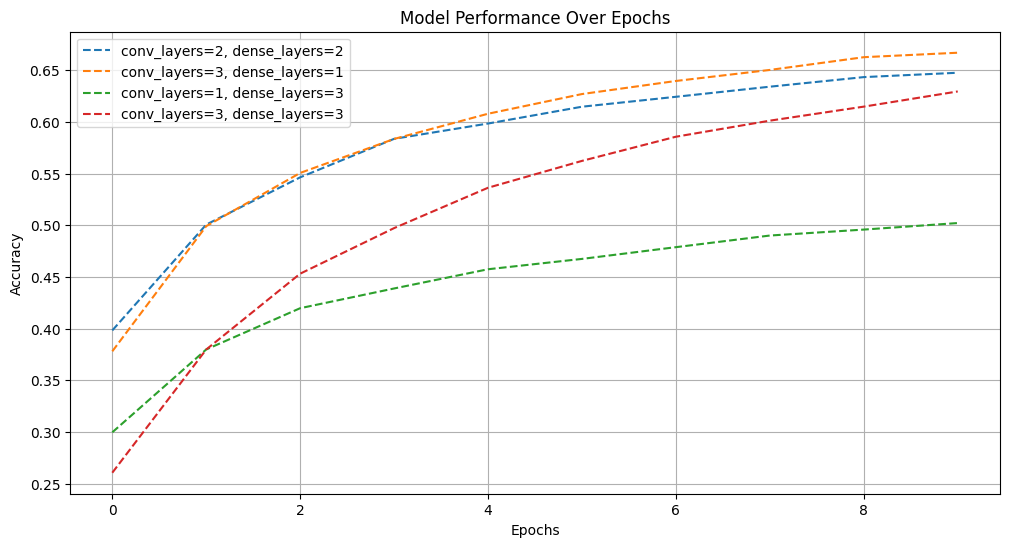

In [34]:
plot_model_performance(results)

## **Data Preparation and Model Training Configuration**

In [5]:
BATCH_SIZE = 64
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [8]:
new_model = create_model(conv_layers=3, dense_layers=1, l2_regularization=0.001)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
early_stopping = EarlyStopping(monitor='loss', patience=3, mode='min')
hist = new_model.fit(train_dataset, epochs=50, steps_per_epoch= num_train_examples//BATCH_SIZE, callbacks=[early_stopping],)

Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3312 - loss: 1.9760
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5320 - loss: 1.3624
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5935 - loss: 1.2078
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6351 - loss: 1.1048
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6581 - loss: 1.0484
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6800 - loss: 0.9890
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6906 - loss: 0.9676
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7071 - loss: 0.9329
Epoch 9/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7150 - loss: 0.9047
Epoch 10/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7233 - loss: 0.8929
Epoch 11/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7278 - loss: 0.8797
Epoch 12/50
781/781 ━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_12020\2867326721.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


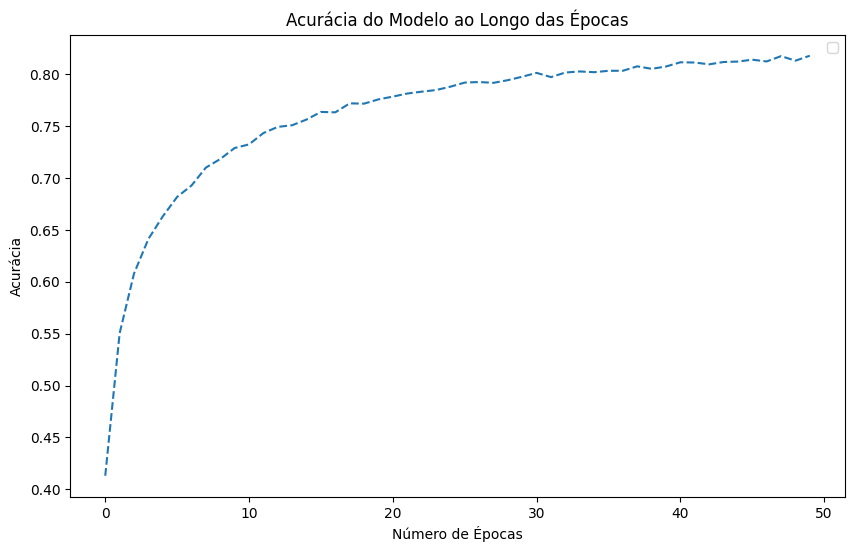

In [10]:
# Acessando as métricas de acurácia para treino e validação
accuracy = hist.history['accuracy']

# Gerando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(accuracy, linestyle='--')

# Adicionando título e rótulos aos eixos
plt.title('Acurácia do Modelo ao Longo das Épocas')
plt.xlabel('Número de Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Exibindo o gráfico
plt.show()

In [11]:
test_loss, test_accuracy = new_model.evaluate(test_dataset)
print('Accuracy on test dataset:', test_accuracy)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7884 - loss: 0.7678
Accuracy on test dataset: 0.7842000126838684
